counts in f_st =  100000000.00000004
counts in z_g =  99547752.0
counts in z_p =  99180753.0


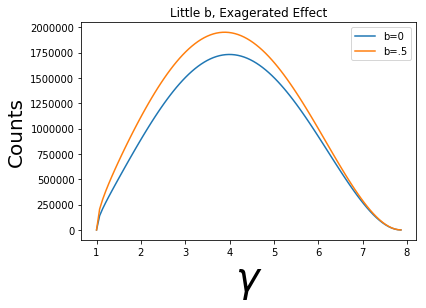

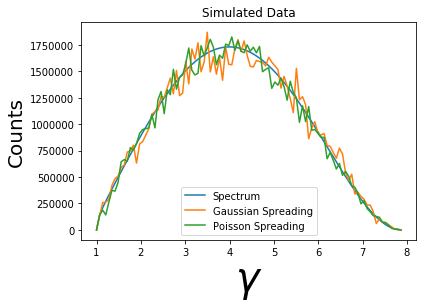

In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt


# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#

N = 1e8  # number of counts (simulated).
n1 = 1  # normalization constant for fit
n2 = .5  # normalization constant for fit
n_x = 100  # number of energy bins

# ---------------------------------------------------------#


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in eV


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0)
sum1 = sum(f_st)  # using the sum of the list to normalize.
f_st = f_st * N / sum1  # actually need to think about where this happens before or after y_fit
y_fit = n1*f_st + n2*f_st/x  # maybe just need to renormalize y_fit here.
sum2 = sum(y_fit)  # using the sum of the list to normalize. This is what I want to use, right? 

y_gdata = np.around(N/sum1*np.random.normal(spect_data(x, e0), spect_data(x, e0) ** .5))  # Normalizing and rounding (gaussian)
y_pdata = np.around(N/sum1*np.random.poisson(spect_data(x, e0)))  # Normalizing and rounding (poisson)


print('counts in f_st = ',sum(f_st))
print('counts in z_g = ',sum(y_gdata))  # Note that these y_data's are not correctly normalized at the moment (I think.. But sum2 did weird things)
print('counts in z_p = ',sum(y_pdata))


plt.plot(x, f_st, x, y_fit)  # Test plots
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Little b, Exagerated Effect")
plt.gca().legend(('b=0', 'b=.5'))

plt.show()

plt.plot(x, f_st, x, y_gdata, x, y_pdata)  # Plotting the simulated data
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('Spectrum', 'Gaussian Spreading', 'Poisson Spreading'))

plt.show()


In [35]:
# The simulated data seems like the variance is not scaling with 1/root(N)? More like root(N) maybe... 


#Ok I can just write comments in here I guess also to narrate what I'm doing. It also seems like this notebook
# would be good to accompany a proper python project in pyCharm
# Next I'm going to write the linear fit function. Would be nice for this to be somewhat stand-alone. 

[[9.74921453e+00 5.87287328e-01 6.02394506e-02]
 [1.00055782e+01 1.88422179e-02 1.88317133e-03]]


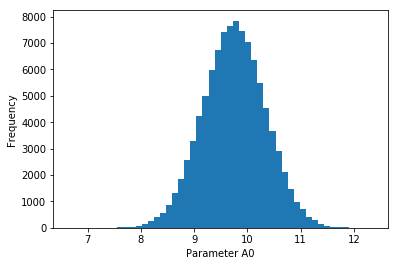

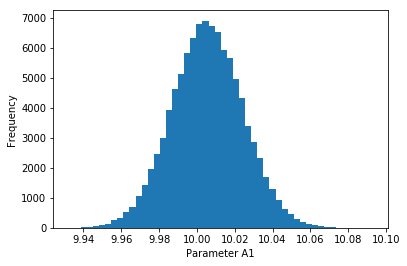

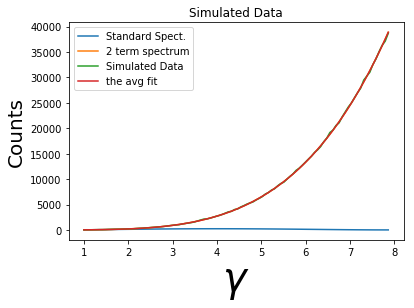

In [9]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#

N = 1e8    # number of counts (simulated).
n1 = 10    # normalization constant for fit
n2 = 10    # normalization constant for fit
n_x = 100  # number of energy bins
n_M = 2    # number of fit parameters 
# ---------------------------------------------------------#


def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma (pretty sure)


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0)
# f_st[0]  = .000001  # Need to see what changing this number does to the fit... These elements are zero. Could this be my issue?
# f_st[99] = .000001

y_fit = n1*x**2 + n2*x**4  # Test Function

#y_fit = n1*f_st + n2*f_st/x  # True Function. 

# #y_pdata = np.around(N/sum1*np.random.poisson(spect_data(x, e0)))  # Normalizing and rounding (poisson)
# y_gdata = np.around(np.random.normal(y_fit, y_fit ** .5)) 
# y_gdata[0] = 1  # Need to see what changing this number does to the fit... 
# y_gdata[99] = 1 





# --------------------Many Trials--------------------#

n_fits = 100000 # Sets of fake data analyzed 

P = np.zeros(shape=(n_M,n_fits)) # Fit parameters 
j = 0 

while j < n_fits: 
    # --------------------Faking Data--------------------#
    y_gdata = np.around(np.random.normal(y_fit, y_fit ** .5)) 
#     y_gdata[0] = 1  # Need to see what changing this number does to the fit... 
#     y_gdata[99] = 1 

    # --------------------Putting together the Toolbox 15.4.1-3--------------------#

    X = np.array([x**2,x**4]).transpose() # basis functions. 
    sigma = y_gdata**.5  # going with gaussian random data for now
    
    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x,n_M))
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1

    b = y_gdata/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta
    
    j += 1 
    
    
# --------------------statistics on P --------------------#    

P_stats = np.zeros(shape=(n_M,3))
l = 0
while l < n_M: 
    P_stats[l,0]= np.mean(P[l,:])
    P_stats[l,1]= np.std(P[l,:])
    P_stats[l,2]= np.std(P[l,:])/np.mean(P[l,:]) #Relative Uncertianty
    l += 1 
print(P_stats)
#print(P.transpose()) 
k = 0
while k < n_M: 
    plt.hist(P[k,:], bins=50)
    plt.ylabel('Frequency')
    plt.xlabel('Parameter A%d' % k)
    plt.show()
    k += 1 

y_fit_real =  P_stats[0,0]*x**2 + P_stats[1,0]*x**4

plt.plot(x, f_st, x, y_fit, x, y_gdata, x, y_fit_real)  # Plotting the simulated data
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('Standard Spect.', '2 term spectrum', 'Simulated Data', 'the avg fit'))

plt.show()

# Things that may be useful 
# Note: Need to redo this normalizing asap. Maybe. Now think it may be ok.. 


# # General Linear Least Squares (Based on 15.4 in Numerical Recipes) (CODE ADAPTED FROM General Linear Least Squares jupyter notebook)

# # --------------------Putting together the Toolbox 15.4.1-3--------------------#

# P = np.ones(n_M) # M=2 fit parameters
# X = np.array([f_st,x**2]).transpose() # basis functions. 
# sigma = y_gdata**.5  # going with gaussian random data for now

# # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
# A = np.zeros(shape=(n_x,n_M))

# i=0
# while i < n_M:
#     A[:,i] = X[:,i]/sigma
#     i += 1

# b = y_gdata/sigma

# alpha = A.transpose() @ A  #NR 15.5.8
# beta = A.transpose() @ b   #NR 15.5.9

# P = np.linalg.inv(alpha) @ beta


# print(P)



this shoulod be exactly N -> 99999999.99999993


/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt


0.003


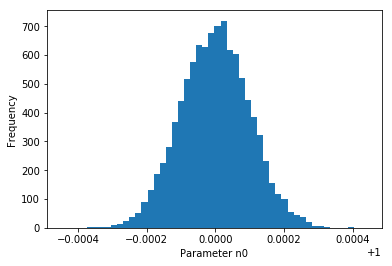

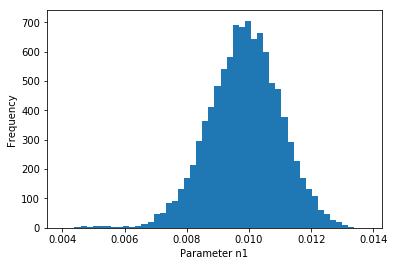

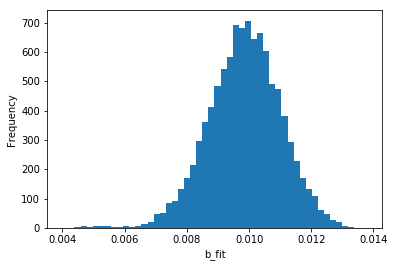

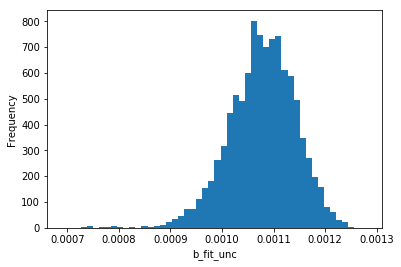

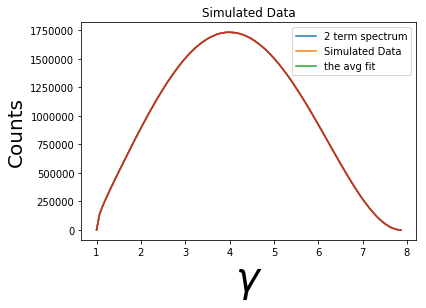

In [211]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#
N = 1e8    # number of counts (simulated).
lil_b = 1e-2
n_x = 100  # number of energy bins
n_M = 2    # number of fit parameters 
# ---------------------------------------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma (pretty sure)


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit(A,B):
    return A*f_st + B/x # Test Function



# --------------------Normalizing Constants--------------------#

n1_init = 100000   # There are issues if I make this too small which I think have to do with rounding. 
norm = sum(y_fit(n1_init,lil_b*n1_init))  # Evaluate with n1_init first to normalize 

C_norm = n1_init*N/norm

n1 = C_norm   # normalization constant for fit
n2 = lil_b*C_norm    # normalization constant for fit

print('this shoulod be exactly N ->', sum(y_fit(n1,n2)))



# --------------------Many Trials--------------------#

n_fits = 10000 # Sets of fake data analyzed 

P = np.zeros(shape=(n_M,n_fits)) # Fit parameters n1, n2
P_unc = np.zeros(shape=(n_M,n_fits)) # Fit uncert's (NR 15.4.15)
b_fit = np.zeros(shape=(n_fits))  # get b from n1, n2 
b_fit_unc = np.zeros(shape=(n_fits)) #uncert in b for each fit. 

j = 0 

while j < n_fits: 
    
    # --------------------Faking Data--------------------#
    y_gdata = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) 

    # --------------------Putting together the Toolbox 15.4.1-3--------------------#

    X = np.array([f_st,1/x]).transpose() # basis functions. 
    sigma = y_gdata**.5  # going with gaussian random data for now
   
    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x,n_M))
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1

    b_matrix = y_gdata/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b_matrix   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta
    
    # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
    i=0
    while i < n_M:
        P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
        i += 1
    b_fit[j] = P[1,j]/P[0,j] # b = n2/n1
    b_fit_unc[j] = P[1,j]/P[0,j] *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2)**.5 #uncert in b using error propigation 
    # need to inspect the covariance matrix to make sure this is acceptable (so off diagonal elements must be zero?)
    
    j += 1 
# --------------------Debugging to see why I get these Nans --------------------#    

#This prints the number of nan pairs I get in my P matrix
print(np.argwhere(np.isnan(P)).shape[0]/n_fits)

# --------------------statistics on P --------------------#    

P_stats = np.zeros(shape=(n_M,3))
l = 0
while l < n_M: 
#     P_stats[l,0]= np.mean(P[l,:]*norm/(n1_init*N))
#     P_stats[l,1]= np.std(P[l,:]*norm/(n1_init*N))
    P_stats[l,0]= np.mean(P[1,:]/P[0,:])
    P_stats[l,1]= np.std(P[1,:]/P[0,:])
#     P_stats[l,2]= np.mean(P_unc[l,:])
    #     P_stats[l,2]= np.std(P[l,:]*norm/(n1_init*N))/np.mean(P[l,:]*norm/(n1_init*N)) #Relative Uncertianty
    l += 1 


# -------------------- Plotting n1,n2,b (fit histogram)  --------------------# 

k = 0
while k < n_M: 
    plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
    plt.ylabel('Frequency')
    plt.xlabel('Parameter n%d' % k)
    plt.show()
    k += 1 
    
plt.hist(b_fit, bins=50)
plt.ylabel('Frequency')
plt.xlabel('b_fit')
plt.show()

plt.hist(b_fit_unc, bins=50)
plt.ylabel('Frequency')
plt.xlabel('b_fit_unc')
plt.show()
    
    
y_fit_real =  y_fit(n1,n2)
y_fit_fit = y_fit(C_norm, C_norm*b_fit[12])

plt.plot(x, C_norm*f_st, x, y_fit_real, x, y_fit_fit, x, y_gdata) # Plotting the fits. Should plot simulated data as well
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('2 term spectrum', 'Simulated Data', 'the avg fit'))

plt.show()




this shoulod be exactly N -> 100000000.00000007


/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/home/drewbyron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


0.0102


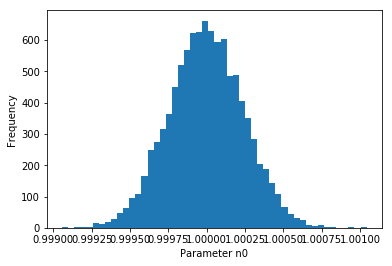

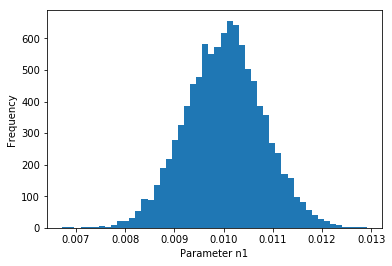

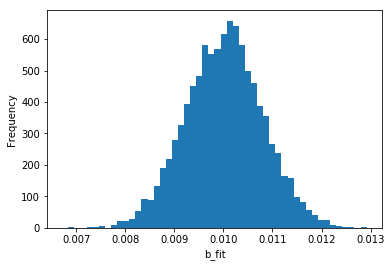

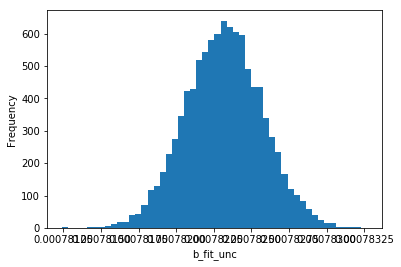

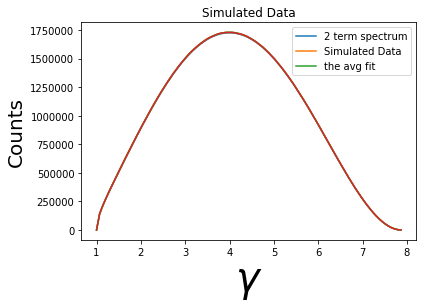

In [227]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

# -------------------Physical Constants-------------------#

me = 5.11e5  # electron mass in eV/c^2

# --------------------Input Parameters--------------------#
N = 1e8    # number of counts (simulated).
lil_b = 1e-2
n_x = 100  # number of energy bins
n_M = 2    # number of fit parameters 
# ---------------------------------------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma (pretty sure)


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum
f_st[0] = 1e-3
f_st[99] = 1e-3

def y_fit(A,B):
    return A*f_st + B*f_st/x # Test Function


# --------------------Normalizing Constants--------------------#

n1_init = 1000   # There are issues if I make this too small which I think have to do with rounding. 
norm = sum(y_fit(n1_init,lil_b*n1_init))  # Evaluate with n1_init first to normalize 

C_norm = n1_init*N/norm

n1 = C_norm   # normalization constant for fit
n2 = lil_b*C_norm    # normalization constant for fit

# print(y_fit(n1,n2)) 
print('this shoulod be exactly N ->', sum(y_fit(n1,n2)))



# --------------------Many Trials--------------------#

n_fits = 10000 # Sets of fake data analyzed 

P = np.zeros(shape=(n_M,n_fits)) # Fit parameters n1, n2
P_unc = np.zeros(shape=(n_M,n_fits)) # Fit uncert's (NR 15.4.15)
b_fit = np.zeros(shape=(n_fits))  # get b from n1, n2 
b_fit_unc = np.zeros(shape=(n_fits)) #uncert in b for each fit. 

j = 0 

while j < n_fits: 
    
    # --------------------Faking Data--------------------#
    y_gdata = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) 

    # --------------------Putting together the Toolbox 15.4.1-3--------------------#

    X = np.array([f_st,f_st/x]).transpose() # basis functions. 
    sigma = y_gdata**.5  # going with gaussian random data for now
   
    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x,n_M))
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1

    b_matrix = y_gdata/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b_matrix   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta
    
    # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
    i=0
    while i < n_M:
        P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
        i += 1
    b_fit[j] = P[1,j]/P[0,j] # b = n2/n1
    b_fit_unc[j] = P[1,j]/P[0,j] *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2)**.5 #uncert in b using error propigation 
    # need to inspect the covariance matrix to make sure this is acceptable (so off diagonal elements must be zero?)
    
    j += 1 
# --------------------Debugging to see why I get these Nans --------------------#    

#This prints the number of nan pairs I get in my P matrix
print(np.argwhere(np.isnan(P)).shape[0]/(2*n_fits))

# --------------------statistics on P --------------------#    

P_stats = np.zeros(shape=(n_M,3))
l = 0
while l < n_M: 
#     P_stats[l,0]= np.mean(P[l,:]*norm/(n1_init*N))
#     P_stats[l,1]= np.std(P[l,:]*norm/(n1_init*N))
    P_stats[l,0]= np.mean(P[1,:]/P[0,:])
    P_stats[l,1]= np.std(P[1,:]/P[0,:])
#     P_stats[l,2]= np.mean(P_unc[l,:])
    #     P_stats[l,2]= np.std(P[l,:]*norm/(n1_init*N))/np.mean(P[l,:]*norm/(n1_init*N)) #Relative Uncertianty
    l += 1 


# -------------------- Plotting n1,n2,b (fit histogram)  --------------------# 

k = 0
while k < n_M: 
    plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
    plt.ylabel('Frequency')
    plt.xlabel('Parameter n%d' % k)
    plt.show()
    k += 1 
    
plt.hist(b_fit, bins=50)
plt.ylabel('Frequency')
plt.xlabel('b_fit')
plt.show()

plt.hist(b_fit_unc, bins=50)
plt.ylabel('Frequency')
plt.xlabel('b_fit_unc')
plt.show()
    
    
y_fit_real =  y_fit(n1,n2)
y_fit_fit = y_fit(C_norm, C_norm*b_fit[12])

plt.plot(x, C_norm*f_st, x, y_fit_real, x, y_fit_fit, x, y_gdata) # Plotting the fits. Should plot simulated data as well
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('$ \gamma $', fontsize = 40)
plt.ylabel('Counts', fontsize = 20)
plt.title("Simulated Data")
plt.gca().legend(('2 term spectrum', 'Simulated Data', 'the avg fit'))

plt.show()




this shoulod be exactly N -> 100000000.0000002
[[0.20504461 0.17601541]
 [0.20770752 0.17725569]
 [0.21024044 0.17837122]
 [0.21259222 0.17932104]
 [0.21661721 0.18166312]
 [0.21759576 0.18143814]
 [0.21962004 0.18208272]
 [0.22232376 0.18328012]
 [0.22616848 0.18539935]
 [0.22816123 0.18598521]
 [0.23071205 0.18701692]
 [0.23214873 0.18713907]
 [0.23537333 0.18869321]
 [0.23644289 0.18851214]
 [0.23829782 0.18895579]
 [0.24149199 0.19045082]
 [0.2430873  0.1906756 ]
 [0.24406906 0.19041927]
 [0.2480689  0.1925078 ]
 [0.25047186 0.19334152]
 [0.25096497 0.1927    ]
 [0.25369031 0.19377019]
 [0.25594672 0.19447291]
 [0.25697598 0.19424076]
 [0.25892302 0.19470115]
 [0.26055032 0.19491761]
 [0.262847   0.19563005]
 [0.26370909 0.19527296]
 [0.26638652 0.1962569 ]
 [0.26806687 0.19650005]
 [0.27034803 0.19717896]
 [0.27149863 0.19703064]
 [0.27499476 0.19857753]
 [0.27609404 0.19838689]
 [0.27758357 0.19847715]
 [0.28054511 0.19961391]
 [0.27987544 0.19816848]
 [0.2824295  0.1990086 ]
 [0

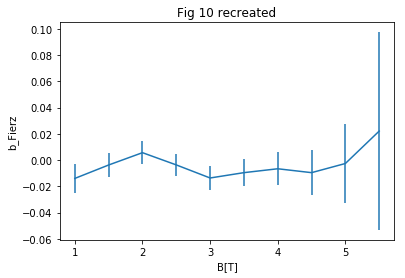

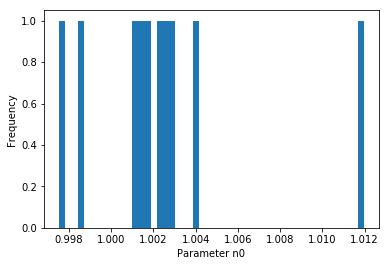

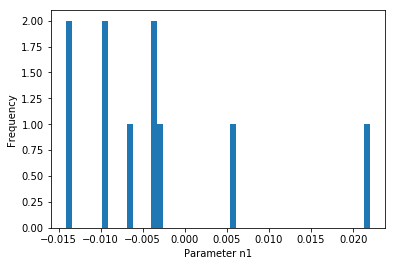

In [54]:
# Here I am parsing the data by field and redoing Alejandro's Fig. 10 in our proposal.
# Note that NR denotes Numerical Recipes so that you can follow along with the math. 

%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import math


# -------------------Physical (or natural) Constants -------------------#

me = 5.11e5  # electron mass in eV/c^2
c = 3*10**8
pi= math.pi


# --------------------Input Parameters--------------------#

N = 1e8    # number of counts (simulated).
lil_b = 2e-3 # little b value
n_x = 1000  # number of energy bins in entire spectrum 
n_M = 2    # number of fit parameters 


# -----------------Constructing the Standard (b=0) beta spectrum-------------------------#

def spect_data(e, e0):
    return (e-e0)**2*e*(e**2-1)**.5


e0 = 3.508e6/me + 1  # Helium Endpoint in terms of gamma, or total energy in units of me.


x = np.linspace(1, e0, n_x)  # 100 linearly spaced numbers

f_st = spect_data(x, e0) #Undistorted, "standard" spectrum

def y_fit(A,B):
    return A*f_st + B*f_st/x # This function is used to create fake data and to fit. lil_b = B/A. 


# --------------------Normalizing--------------------#

n1_init = 1000   # I use this to create an initital spectrum and then renormalize to get N total counts.  
norm = sum(y_fit(n1_init,lil_b*n1_init))  # norm is the total number of "counts" initially.

C_norm = n1_init*N/norm  # renormalization constant

n1 = C_norm   
n2 = lil_b*C_norm    


print('this shoulod be exactly N ->', sum(y_fit(n1,n2))) # Verifying that the normalization worked. 



# ----------------Setting up the different arrays necessary for the fitting  ------------------------#

n_B = 10 # Sets number of different field strengths we will run with 

P = np.zeros(shape=(n_M,n_B)) # Fit parameters n1, n2 for each field configuration
P_unc = np.zeros(shape=(n_M,n_B)) # Fit uncertainies for each field configuration (NR 15.4.15)
b_fit = np.zeros(shape=(n_B))  # b (from n1, n2) for each field configuration
b_fit_unc = np.zeros(shape=(n_B)) # uncertainty in b for for each field configuration


# --------------------Faking Data --------------------#

y_gdata = np.around(np.random.normal(y_fit(n1,n2), (y_fit(n1,n2)) ** .5)) # Gaussian random data. 


# --------------------Boundries in Energy for different fields and a fixed 18-24 Ghz bandwidth --------------------#

E_boundries_high = np.zeros(shape=(n_B))  # Upper/Lower bounds in energy for a given B field 
E_boundries_low = np.zeros(shape=(n_B))  

ftoE = c**2/(me*2*pi)  # Note that this is more aptly f to gamma b/c E is measured in units of m_e
B_start = 1 # B field starting at 1 T
B_inc = .5  # B field increased in units of .5 T
f_min = 18e9 # GHz
f_max = 24e9 # GHz


h = 0
while h < n_B:
    E_boundries_high[h] = ftoE*(B_start + h*B_inc)/f_min
    E_boundries_low[h] = ftoE*(B_start + h*B_inc)/f_max  
    h += 1 

    
E_boundries_high_indicies= np.rint((E_boundries_high - 1)*n_x/(e0-1)) # Indicies of the energy bounds
E_boundries_low_indicies= np.rint((E_boundries_low - 1)*n_x/(e0-1))   
# Note that there is overlap in energies between fields especially at higher fields

# There can be energies at these fields and bandwidth beyond our endpoint energy.
# Here I am changing those bounds to just be the last bin of our spectrum. 
g = 0 
while g< n_B: 
    if E_boundries_high_indicies[g] >= n_x:
        E_boundries_high_indicies[g] = n_x-1
    if E_boundries_low_indicies[g] >= n_x:
        E_boundries_low_indicies[g] = n_x-1
    g += 1


# --------------------General Linear Least Squares -> n1, n2 -> lil_b (for each field strength) --------------------#

j = 0 
while j < n_B: 
    
    # --------------------Parcing up the relevant arrays --------------------#
    x_temp = x[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    f_st_temp = f_st[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    y_gdata_temp = y_gdata[int(E_boundries_low_indicies[j]):int(E_boundries_high_indicies[j])]
    n_x_temp = len(x_temp)
    

    # --------------------Putting together the Toolbox: NR 15.4.1-3--------------------#

    X = np.array([f_st_temp,f_st_temp/x_temp]).transpose() # basis functions. 
    sigma = y_gdata_temp**.5  # Assuming gaussian random data
   

    # --------------------Creating A,b matricies NR 15.4.4-5--------------------#
    A = np.zeros(shape=(n_x_temp,n_M))
    
    i=0
    while i < n_M:
        A[:,i] = X[:,i]/sigma
        i += 1
    print(A)
    b_matrix = y_gdata_temp/sigma
    alpha = A.transpose() @ A  #NR 15.5.8
    beta = A.transpose() @ b_matrix   #NR 15.5.9

    P[:,j] = np.linalg.inv(alpha) @ beta
    print(np.linalg.inv(alpha)) 
    
    
    # --------------------Variance of Fit Parameters NR 15.4.15--------------------#
    i=0
    while i < n_M:
        P_unc[i,j] = (np.linalg.inv(alpha)[i,i])**.5
        i += 1
    b_fit[j] = P[1,j]/P[0,j] # b = n2/n1
    
    # below is the uncertainty in b using error propigation with a non-zero covariance 
    b_fit_unc[j] = ((P[1,j]/P[0,j])**2 *((P_unc[0,j]/P[0,j])**2 + (P_unc[1,j]/P[1,j])**2) 
                    - 2*(P[1,j]/P[0,j]**3)*np.linalg.inv(alpha)[0,1])**.5 
    j += 1 

    
# --------------------Debugging to see if any of the fits failed --------------------#        

#This prints the number of nan pairs I get in my P matrix
print("this percentage of P is nan",np.argwhere(np.isnan(P)).shape[0]/(2*n_B))

    
# --------------------Recreating Alejandro's Fig 10--------------------#   

B_spect = np.zeros(shape = n_B)  # Array for the x axis of the plot 
j = 0
while j < n_B:
    B_spect[j] = B_start + j*B_inc
    j += 1 
    

plt.figure()
plt.errorbar(B_spect, b_fit, b_fit_unc)
plt.title("Fig 10 recreated")    
plt.ylabel('b_Fierz')
plt.xlabel('B[T]')
plt.show()   


# -------------------- Plotting n1,n2 (histogram)  --------------------# 

k = 0
while k < n_M: 
    plt.hist(P[k,:]*norm/(n1_init*N), bins=50)
    plt.ylabel('Frequency')
    plt.xlabel('Parameter n%d' % k)
    plt.show()
    k += 1 



